In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import dsa
from dsa import *
from models import mlp
import pickle
from sklearn.model_selection import train_test_split

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

def map_y(y):
    if y >= 3400:
        return 4.0
    elif y >= 1800:
        return 3.0
    elif y >= 1200:
        return 2.0
    elif y >= 800:
        return 1.0
    else:
        return 0.0

df = pd.read_csv('../datasets/news-popularity.csv').sample(frac=1)
df = df.drop(columns=["url"])
xy = df.to_numpy()
x = xy[:,1:-1] # remove the first feature as it is not predictive
y = xy[:,-1]
x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
y = np.array([map_y(i) for i in y]).reshape((len(x), 1))

aux_target_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=aux_target_ratio/(aux_target_ratio+1), random_state=42)

target_ds = make_dataset(x_train, y_train, lambda t: t)
aux_ds = make_dataset(x_test, y_test, lambda t: t)

In [3]:
news_dsa = {}
log_news_dsa = {}

for split in [2,3,4]:
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=58, class_num=5, split=split, units=256, ed_act="relu")
    news_dsa[split] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log_news_dsa[split] = news_dsa[split].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        acc_fn=tf.keras.metrics.SparseCategoricalAccuracy(),
        batch_size=32,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.00001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.00001,
        lr_c=0.0001,
        verbose=True,
        log_freq=500)

======Split level is 2======
Iteration 500, train accuracy: 0.2671149980425835, average attack MSE: 0.17251977229118348
Iteration 1000, train accuracy: 0.2766728901863098, average attack MSE: 0.14904684656858444
Iteration 1500, train accuracy: 0.2824649776816368, average attack MSE: 0.12025413571298123
Iteration 2000, train accuracy: 0.2881436363458633, average attack MSE: 0.0864057552665472
Iteration 2500, train accuracy: 0.28996027809381486, average attack MSE: 0.06668195417523384
Iteration 3000, train accuracy: 0.29229153776168826, average attack MSE: 0.06018311989307404
Iteration 3500, train accuracy: 0.2940935758948326, average attack MSE: 0.057811700202524664
Iteration 4000, train accuracy: 0.2961151691675186, average attack MSE: 0.057545667752623555
Iteration 4500, train accuracy: 0.29795320039987566, average attack MSE: 0.05755588788539171
Iteration 5000, train accuracy: 0.2990424091219902, average attack MSE: 0.057153544932603835
Iteration 5500, train accuracy: 0.3006483344435

In [12]:
from fsha import *

news_fsha={}
log_news_fsha={}

for split in [4,3,2]:
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    hparams = {
        'WGAN' : False,
        'style_loss' : None,
        'lr_f' :  0.0005,
        'lr_tilde': 0.0005,
        'lr_D': 0.001,
        'lr_g': 0.001
    }
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp_fsha(attr_num=58, class_num=5, split=split, units=256, ed_act=None)
    models = (make_f, make_g, make_e, make_d, make_c)
    news_fsha[split] = FSHA(
        target_ds, aux_ds,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        acc_fn=tf.keras.metrics.SparseCategoricalAccuracy(), models=models, batch_size=32, hparams=hparams)
    log_news_fsha[split]=news_fsha[split](10000, verbose=True, progress_bar=False, log_frequency=1000)

======Split level is 4======
RUNNING...
Iteration 0000000 train accuracy: 0.1562, validation: 0.1776
Iteration 0001000 train accuracy: 0.2234, validation: 0.1589
Iteration 0002000 train accuracy: 0.2238, validation: 0.1152
Iteration 0003000 train accuracy: 0.2212, validation: 0.0686
Iteration 0004000 train accuracy: 0.2205, validation: 0.0793
Iteration 0005000 train accuracy: 0.2187, validation: 0.0861
Iteration 0006000 train accuracy: 0.2171, validation: 0.1849
Iteration 0007000 train accuracy: 0.2153, validation: 0.0977
Iteration 0008000 train accuracy: 0.2151, validation: 0.0581
Iteration 0009000 train accuracy: 0.2159, validation: 0.0579
======Split level is 3======
RUNNING...
Iteration 0000000 train accuracy: 0.0312, validation: 0.1801
Iteration 0001000 train accuracy: 0.2092, validation: 0.1068
Iteration 0002000 train accuracy: 0.2142, validation: 0.0804
Iteration 0003000 train accuracy: 0.2150, validation: 0.0976
Iteration 0004000 train accuracy: 0.2142, validation: 0.0974
Itera

In [22]:
with open('log/news-dsa.pkl', 'wb') as f:
    pickle.dump(log_news_dsa, f)
with open('log/news-fsha.pkl', 'wb') as f:
    pickle.dump(log_news_fsha, f)

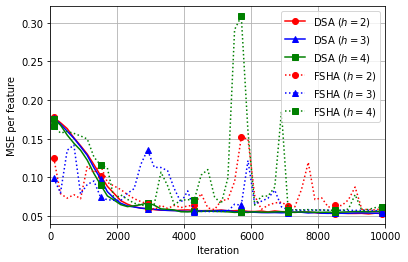

In [20]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,10000])
plt.grid()

sampled_loss = {}
sampled_fsha_loss = {}

for split in [2,3,4]:
    sampled_loss[split] = [sum(log_news_dsa[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_news_dsa[split][:,0])/log_freq))]
    sampled_fsha_loss[split] = [sum(log_news_fsha[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_news_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.ylabel('MSE per feature')
plt.xlabel('Iteration')
plt.plot(ran, sampled_loss[2], 'ro-', ran, sampled_loss[3], 'b^-', ran, sampled_loss[4], 'gs-', markevery=7)
plt.plot(ran, sampled_fsha_loss[2], 'ro:', ran, sampled_fsha_loss[3], 'b^:', ran, sampled_fsha_loss[4], 'gs:', markevery=7)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/news.pdf", bbox_inches='tight')

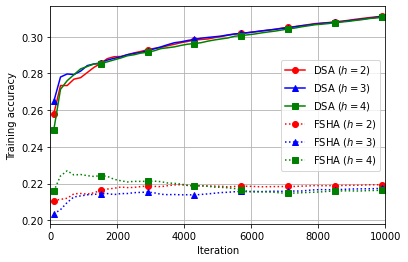

In [21]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,10000])
plt.grid()

sampled_acc = {}
sampled_fsha_acc = {}

for split in [2,3,4]:
    sampled_acc[split] = [sum(log_news_dsa[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_news_dsa[split][:,0])/log_freq))]
    sampled_fsha_acc[split] = [sum(log_news_fsha[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_news_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.ylabel('Training accuracy')
plt.xlabel('Iteration')
plt.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.plot(ran, sampled_fsha_acc[2], 'ro:', ran, sampled_fsha_acc[3], 'b^:', ran, sampled_fsha_acc[4], 'gs:', markevery=7)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.ylabel('Training accuracy')
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/news-acc.pdf", bbox_inches='tight')